# Building a multi-agent with LangGraph 🦜🕸️

In this notebook, we're going to walk through building a multi-agent system in LangGraph that can handle complex customer support queries. We will be deep diving into concepts such as human-in-the-loop, the remote graph interface, and long term memory.

![Architecture](images/architecture.png)

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), and is able to handle customer inqueries related to account information, invoice, and music. **Our goal is to write a supervisor workflow that plans and executes tasks accordingly, utilizing 3 sub-agents that has been built and deployed** by the other members of the team: 
1. Customer information subagent – Manages customer account details (name, address, phone, email).
2. Music catalog information subagent – Provides information about the digital music store’s catalog (albums, tracks, songs).
3. Invoice information subagent – Retrieves a customer’s past purchases or invoices.

For a deeper dive into LangGraph primitives and learning our framework, check out our [LangChain Academy](https://academy.langchain.com/courses/intro-to-langgraph)!


## Part 1. Building the Agent

In [3]:
%pip install python-dotenv langgraph typing-extensions langchain-core langchain-openai langchain-anthropic langchain-community scikit-learn openai ipython openevals


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Setting Up

To start, let's load our environment variables from our .env file. Make sure all of the keys necessary in .env.example are included!
We use OpenAI in this example, but feel free to swap ChatOpenAI with other model providers that you prefer. 

In [4]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv(dotenv_path=".env", override=True)

# For AT&T - specify Azure secrets here
# model = AzureChatOpenAI()
model = ChatOpenAI(model="o3-mini")

#### State

We will now initialize **state**, the shared data structure that’s passed on between the nodes of our customer support agent. It represents the current snapshot of the agent and will track the following elements: 
1. The user's request
2. The action plan of steps to be tackled
3. Executed steps
4. Conversation history 
5. Final response

In [5]:
from typing_extensions import TypedDict
from typing import Annotated, List, Tuple, Literal, Union
from langgraph.graph.message import AnyMessage, add_messages
import operator

class State(TypedDict):
    original_objective: str
    action_plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    messages: Annotated[list[AnyMessage], add_messages]
    response: str

Now, we will create a prompt that will be reused throughout the notebook with context and role for the supervisor agent. 

In [6]:
supervisor_reusable_context = """You are an expert customer support assistant for a digital music store. 
You are dedicated to providing exceptional service and ensuring customer queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from customers. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from customers. 
The multi-agent team you are supervising is responsible for handling questions related to the digital music store's music 
catalog (albums, tracks, songs, etc.), information about a customer's account (name, email, phone number, address, etc.), 
and information about a customer's past purchases or invoices. Your team is composed of three subagents that you can use 
to help answer the customer's request:

1. customer_information_subagent: this subagent is able to retrieve and update the personal information associated with 
a customer's account in the database (specifically, viewing or updating a customer's name, address, phone number, or email).
2. music_catalog_information_subagent: this subagent is able to retrieve information about the digital music store's music 
catalog (albums, tracks, songs, etc.) from the database.
3. invoice_information_subagent: this subagent is able to retrieve information about a customer's past purchases or invoices 
from the database. \n"""

#### Initializing Short-term & Long-term Memory
**Long term memory** lets you store and recall information between conversations. Let's first define the long term memory store where we will be storing user preferences, allowing us to create a personalized user experience. 

We will also initialize a checkpointer for **short-term memory**. Managed as part of the agent's state, short-term memory maintains context within a single thread. 

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initializing long term memory store 
in_memory_store = InMemoryStore()

# Initializing checkpoint for thread-level memory 
checkpointer = MemorySaver()

### Node 1: Supervisor
Now that we have initialized state and memory, we are ready to build our agent! 
Our first node supervisor is responsible for taking in a customer query and generating a list of action plans of which sub-agents to call. It also interacts with the long term memory store to fetch any relevant input.  

To do this, we would want to our LLM to return **structured output** based on a defined schema, informing us a list of sub-agents to be queued. Enforcing structured output is a good way to obtain provide predictable and verifiable data formats from the LLM. 

In [8]:
from pydantic import BaseModel, Field

class Step(BaseModel):
    description: str = Field(description="Description of the step to be performed")
    subagent: Literal["customer_information_subagent", "music_catalog_information_subagent", "invoice_information_subagent"] = Field(
        description="Name of the subagent that should execute this step"
    )
    
class Plan(BaseModel):
    steps: List[Step] = Field(
        description="Different steps that the subagents should follow to answer the customer's request, in chronological order"
    )

In [9]:
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

supervisor_prompt = supervisor_reusable_context + """
Your role is to create an action plan that the subagents can follow and execute to thoroughly answer the customer's request. 
Your action plan should specify the exact steps that should be followed by the subagent(s) in order to successfully answer 
the customer's request, and which subagent should perform each step. Return the action plan as a list of objects, where each 
object contains the following fields:
- step: a detailed step that should be followed by subagent(s) in order to successfully answer a portion of the customer's request.
- subagent_to_perform_step: the subagent that should perform the step.

Return the action plan in chronological order, starting with the first step to be performed, and ending with the last step 
to be performed. You should try your best not to have multiple steps performed by the same subagent. This is inefficient. 
If you need a subagent to perform a task, try and group it all into one step.

You have existing information/long term memory about the customer that you can use to help you create the action plan. 
The existing information about the customer is as follows:
{existing_customer_information}

If you do not need a subagent to answer the customer's request, do not include it in the action plan/list of steps. Your goal 
is to be as efficient as possible, while ensuring that the customer's request is answered thoroughly. Take a deep breath and 
think carefully before responding. Go forth and make the customer delighted!
"""

# helper 
def format_user_memory(user_data):
    """Fetches music preferences from users, if available."""
    profile = user_data['memory']
    result = ""
    if hasattr(profile, 'music_preferences') and profile.music_preferences:
        result += f"Music Preferences: {', '.join(profile.music_preferences)}"
    return result.strip()


# helper 
def format_action_plan(steps_list):
    """
    Process a list of Step objects and format them into a comprehensive summary string.
    
    Args:
        steps_list: List of Step objects with description and subagent attributes
        
    Returns:
        Formatted string with key information about agent actions
    """
    summary = "# ACTION PLAN: \n\n"
    
    for i, step in enumerate(steps_list, 1):
        # Extract information from Step object
        task_description = step.description
        subagent = step.subagent
        
        # Format the action summary
        summary += f"## Action {i}\n\n"
        summary += f"### Agent\n{subagent}\n\n"
        summary += f"### Task\n{task_description}\n\n"
        
        # Add separator between actions except for the last one
        if i < len(steps_list):
            summary += "---\n\n"
    return summary



# Node 
def supervisor(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    """Fetches relevant memory profiles and returns an plan"""
    
    print("\n" + "="*50 + "🎯 SUPERVISOR FUNCTION CALLED" + "="*50)
    
    # Fetch existing user memory from long term memory store 
    user_id = config["configurable"].get("user_id")
    namespace = ("memory_profile", user_id)
    existing_memory = store.get(namespace, "user_memory")
    formatted_memory = ""
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    # Fetch user input  
    first_message = state["messages"][-1]

    # Enforce structured output from LLM 
    structured_model = model.with_structured_output(Plan)
    result = structured_model.invoke([
        SystemMessage(content=supervisor_prompt.format(existing_customer_information=formatted_memory))
    ] + [first_message])

    formatted_action_plan = "Based on the plan, there is no need to route to sub-agents." 
    
    if result.steps: 
        formatted_action_plan = format_action_plan(result.steps)

    print("System Message: " + formatted_action_plan)
    
    return {
        # Update State
        "action_plan": result.steps,
        "original_objective": first_message.content,
        # Streaming intermediatery inputs
        "messages": [SystemMessage(content=formatted_action_plan)]
    }

### Node 2: User input
**Human-in-the-loop** workflows pause execution and allow users to review, adjust, or approve the proposed plan. This is helpful especially for complex enterprise use cases, where human supervision can ensure agent reliability. 

In this node, we will take in the user input and update the objective and action plan accordingly. 

In [10]:
class PlanWithUserInput(BaseModel):
    steps: List[Step] = Field(
        description="Different steps that the subagents should follow to answer the customer's request, in chronological order"
    )
    updated_objective: str = Field(
        description="The updated objective/request from the customer, after taking into account the user's input/ideas for improvement"
    )

In [11]:
from langgraph.types import interrupt, Command

# Prompt 

replan_with_user_input_prompt = supervisor_reusable_context + """
Before you, another supervisor/planner has already created an action plan for the subagents to follow. 
This action plan was then shown to the customer so they could provide feedback and ideas for improvement. 

Your job is to take the customer's feedback and update the action plan and their original request/objective 
accordingly. Below, I have attached the previous action plan, the customer's original request/objective that 
the action plan was created for, and the feedback/ideas for improvement from the customer.

Please take this feedback and construct a new action plan/original objective that the subagents can follow to 
thoroughly answer the customer's request. If the feedback is not relevant or nonsensical, you can ignore it, 
and keep the original action plan/original objective.

The updated action plan should specify the exact steps that should be followed by the subagent(s) in order to 
successfully answer the customer's request, and which subagent should perform each step. Return the action plan 
as a list of objects, where each object contains the following fields:
- step: a detailed step that should be followed by the subagent(s) in order to successfully answer a portion of 
the customer's request.
- subagent_to_perform_step: the subagent that should perform the step.

The updated objective should be a detailed description of the customer's request/objective, after taking into 
account the customer's feedback/ideas for improvement.

Return the action plan in chronological order, starting with the first step to be performed, and ending with 
the last step to be performed. You should try your best not to have multiple steps performed by the same subagent. 
This is inefficient. If you need a subagent to perform a task, try and group it all into one step.

If you do not need a subagent to answer the customer's request, do not include it in the action plan/list of steps. 
Your goal is to be as efficient as possible, while ensuring that the customer's request is answered thoroughly and 
to the best of your ability.

Use the information below to update the action plan and customer's objective based on their feedback/ideas for improvement.

*IMPORTANT INFORMATION BELOW*

Your original objective/request from the customer was this:
{original_objective}

The original action plan constructed by the previous supervisor/planner was this:
{formatted_action_plan}

The customer's feedback/ideas for improvement are as follows:
{user_input}
"""



# Node 
def human_input(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    print("\n" + "="*50 + "👤 HUMAN INPUT FUNCTION CALLED" + "="*50)
    
    user_input = interrupt({"Task": "Review the generated plan and suggest any revisions."})
    
    original_objective = state["original_objective"]
    formatted_action_plan = format_action_plan(state["action_plan"])
    
    # structure model output 
    structured_model = model.with_structured_output(PlanWithUserInput)
    
    if user_input != "": 
        result = structured_model.invoke([SystemMessage(content=replan_with_user_input_prompt.format(original_objective=original_objective, formatted_action_plan=formatted_action_plan, user_input=user_input))])
        updated_action_plan = "Updated action plan based on user proposal: \n" + format_action_plan(result.steps)
        print(updated_action_plan)
        return {
            # update state 
            "action_plan": result.steps,
            "original_objective": result.updated_objective,
            "messages": [SystemMessage(content=updated_action_plan)]
        }
    else:
        update_msg = "No updates from user input. Will proceed with the original plan."
        print("System Message: " + update_msg)
        return{
            "messages": [SystemMessage(content=update_msg)]
        }

### Node 3. Agent executor

**RemoteGraph** in the LangGraph Platform enables seamless interaction with deployed agents, making them function like locally defined graphs.

In this case, my teammates have independently built and deployed three specialized subagents:
1. customer_information_subagent – Manages customer account details (name, address, phone, email).
2. music_catalog_information_subagent – Provides information about the digital music store’s catalog (albums, tracks, songs).
3. invoice_information_subagent – Retrieves a customer’s past purchases or invoices.

The agent_executor node determines the sub-agent to route based on the action plan and leverages RemoteGraph to interact with these deployed agents. This approach allows us to reuse existing applications efficiently without writing additional code.

In [12]:
from langgraph.pregel.remote import RemoteGraph
customer_information_deployment_url = "https://react-customer-0485b42e7d885c0fbdad3852a8c0286f.us.langgraph.app"
music_catalog_information_deployment_url = "https://react-music-agent-e21b47f80669524ba69076ff9d720af7.us.langgraph.app"
invoice_information_deployment_url = "https://react-invoice-agent-3913487acf2c5d63ba166fcc35d01641.us.langgraph.app"

customer_information_remote_graph = RemoteGraph("agent", url=customer_information_deployment_url)
music_catalog_information_remote_graph = RemoteGraph("agent", url=music_catalog_information_deployment_url)
invoice_information_remote_graph = RemoteGraph("agent", url=invoice_information_deployment_url)

In [13]:
def agent_executor(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    print("\n" + "="*50 + "🤖 AGENT EXECUTOR FUNCTION CALLED" + "="*50)
    plan = state["action_plan"]

    if plan: 
        total_plan = "\n".join([
            f"{i+1}. {step.subagent} will: {step.description}" 
            for i, step in enumerate(plan)
        ])
        first_task_subagent = plan[0].subagent
        first_task_description = plan[0].description
        first_task_subagent_response = first_task_subagent + " executed logic to answer the following request from the planner/supervisor: " + first_task_description + ".\n Please output your report on your work progress to your supervisor as a update on your action and progress, rather than a end-user facing message. "
        task_formatted_prompt = f"""For the following plan: 
        {total_plan}
        You are tasked with executing the first step #1. {first_task_subagent} will: {first_task_description}
        """
        # Calls the appropriate sub-agent with context
        if first_task_subagent == "customer_information_subagent":
            response = customer_information_remote_graph.invoke({"messages": [HumanMessage(content=task_formatted_prompt)]})["messages"]
            final_response = response[-1]['content']
        elif first_task_subagent == "music_catalog_information_subagent":
            response = music_catalog_information_remote_graph.invoke({"messages": [HumanMessage(content=task_formatted_prompt)]})["messages"]
            final_response = response[-1]['content']
        elif first_task_subagent == "invoice_information_subagent":
            response = invoice_information_remote_graph.invoke({"messages": [HumanMessage(content=task_formatted_prompt)]})["messages"]
            final_response = response[-1]['content']

        system_msg = "Executed " + first_task_subagent + ":\n" + final_response
        print("System Message: " + system_msg)
            
        return {
            # Update State 
            "past_steps": [
                (first_task_subagent_response, final_response)
            ],
            "messages": [SystemMessage(content=system_msg)]
    } 
    else: 
        system_msg = "No agent executed based on current plan. Proceeding to replanner step."
        print("System Message: " + system_msg)
        return {
            "messages": [SystemMessage(content=system_msg)]
    } 
    

### Step 4: Replanner
The **replanner** step reviews completed actions and updates the plan, catching scenarios where the customer’s request isn’t fully addressed or mistakes occur. It can as a built-in fault tolerance mechanism, ensuring the customer’s request is handled accurately.

In [14]:
class Response(BaseModel):
    """Response to user."""
    response: str


class ReplannerResponse(BaseModel):
    action: Union[Response, Plan] = Field(
        description="The action to perform. If you no longer need to use the subagents to solve the customer's request, use Response. "
        "If you still need to use the subagents to solve the problem, construct and return a list of steps to be performed by the subagents, use Plan."
    )

In [15]:
replanner_prompt = supervisor_reusable_context + """Before you, another supervisor/planner has already created an action 
plan for the subagents to follow. I've attached the previous action plan, the customer's original request, and the steps 
that have already been executed by the subagents below. 
You should take this information and either update the plan, or return Response if you believe the customer's request has been answered 
thoroughly and you no longer need to use the subagents to solve the problem (including when their inquiry doesn't need any subagents).  

If you decide to update the action plan, your action plan should specify the exact steps that should be followed by the 
subagent(s) in order to successfully answer the customer's request, and which subagent should perform each step. Return 
the action plan as a list of objects, where each object contains the following fields:
- step: a detailed step that should be followed by subagent(s) in order to successfully answer a portion of the customer's request.
- subagent_to_perform_step: the subagent that should perform the step.

Return the action plan in chronological order, starting with the first step to be performed, and ending with the last step to be performed. 
You should try your best not to have multiple steps performed by the same subagent. This is inefficient. If you need a subagent to 
perform a task, try and group it all into one step.

If you do not need a subagent to answer the customer's request, do not include it in the action plan/list of steps. Your goal 
is to be as efficient as possible, while ensuring that the customer's request is answered thoroughly and to the best of your ability.

Use the information below to either update the action plan, or return Response if you believe the customer's request has been 
answered thoroughly and you no longer need to use the subagents to solve the problem. If you return Response, make sure it's a neatly formatted, thorough response that can be shown
to a customer. Make sure the response has all the information the customer needs, and is professional and friendly.

*IMPORTANT INFORMATION BELOW*

Your original objective/request from the customer was this:
{original_objective}

The original action plan constructed by the previous supervisor/planner was this:
{formatted_action_plan}

The subagents have already executed the following steps:
{formatted_steps}

If no more steps are needed and you are ready to respond to the customer, use Response. If you still need to use the subagents to solve the problem, construct and return a list of steps to be performed by the subagents using Plan.
"""


# helpers 
def format_steps(steps_list):
    """
    Convert a list of Step objects into a neatly formatted string.
    
    Args:
        steps_list: List of Step objects
        
    Returns:
        A formatted string containing all key information
    """
    formatted_output = "# STEPS ALREADY PERFORMED BY THE SUBAGENTS\n\n"
    
    for i, step in enumerate(steps_list, 1):
        context_on_step = step[0]
        result_of_step = step[1]
        formatted_output += f"## Step {i}\n\n"
        formatted_output += f"### Task Description\n{context_on_step}\n\n"
        formatted_output += f"### Result\nThe following is the response returned after the subagent performed the task above:\n\n"
        # Add the result content
        formatted_output += f"{result_of_step}\n\n"    
        # Add separator between steps
        if i < len(steps_list):
            formatted_output += "---\n\n"
    return formatted_output


# Node 
def replanner(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    print("\n" + "="*50 + "🔄 REPLANNER FUNCTION CALLED" + "="*50)
    
    # Fetch from state 
    original_objective = state["original_objective"]
    previous_action_plan = state["action_plan"]
    previous_steps = state["past_steps"]

    # format action steps & action plan 
    formatted_action_plan = format_action_plan(previous_action_plan)
    formatted_steps = format_steps(previous_steps)

    # structured output with response or updated action_plan 
    structured_model = model.with_structured_output(ReplannerResponse)
    result = structured_model.invoke([SystemMessage(content=replanner_prompt.format(original_objective = original_objective, formatted_action_plan = formatted_action_plan, formatted_steps = formatted_steps) )])
    if isinstance(result.action, Response):
        print("System Message: " + result.action.response)
        return {"response": result.action.response, "messages": [SystemMessage(content=result.action.response)]}
    else:
        formatted_update_plan = "Action plan has been updated. \n" + format_action_plan(result.action.steps)
        print("System Message: " + formatted_update_plan)
        return {"action_plan": result.action.steps, "messages": [SystemMessage(content=formatted_update_plan)]}

If all the steps are executed, we would want to output the response to user. Otherwise, we want the execution to continue. To do this, we will utilize a **conditional edge** and define the logic: 
1. If plan has finished executing, update user memory before routing to END 
2. Otherwise, route back to the agent_executor

In [16]:
class UserProfile(BaseModel):
    customer_id: str = Field(
        description="The customer ID of the customer"
    )
    music_preferences: List[str] = Field(
        description="The music preferences of the customer"
    )

In [17]:
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and a customer support assistant. The customer support assistant works for a digital music store, and has utilized a multi-agent team to answer the customer's request. 
You are tasked with analyzing the conversation that has taken place between the customer and the customer support assistant, and updating the memory profile associated with the customer. The memory profile may be empty. If it's empty, you should create a new memory profile for the customer.

You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The customer's memory profile should have the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

These are the fields you should keep track of and update in the memory profile. If there has been no new information shared by the customer, you should not update the memory profile. It is completely okay if you do not have new information to update the memory profile with. In that case, just leave the values as they are.

*IMPORTANT INFORMATION BELOW*

The conversation between the customer and the customer support assistant that you should analyze is as follows:
{conversation}

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

Ensure your response is an object that has the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

For each key in the object, if there is no new information, do not update the value, just keep the value that is already there. If there is new information, update the value. 

Take a deep breath and think carefully before responding.
"""

def should_end(state: State, config: RunnableConfig, store: BaseStore):
    print("\n" + "="*50+"🎬 SHOULD_END FUNCTION CALLED"+"="*50)
    
    past_messages = state["messages"]
    
    if "response" in state and state["response"]:
        # Fetch and update memory 
        user_id = config["configurable"].get("user_id")
        namespace = ("memory_profile", user_id)
        existing_memory = store.get(namespace, "user_memory")
        if existing_memory and existing_memory.value:
            existing_memory_dict = existing_memory.value
            formatted_memory = (
                f"Music Preferences: {', '.join(existing_memory_dict.get('music_preferences', []))}"
            )
        else:
            formatted_memory = ""
        formatted_system_message = SystemMessage(content=create_memory_prompt.format(conversation=past_messages, memory_profile=formatted_memory))
        structured_model = model.with_structured_output(UserProfile)
        updated_memory = structured_model.invoke([formatted_system_message])
        key = "user_memory"
        store.put(namespace, key, { "memory": updated_memory })
        return END
    else:
        return "agent_executor"

### Compile Graph
Now that we've defined our memory store and nodes, let's put it all together and construct our agent!

In [18]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

builder = StateGraph(State)
builder.add_node("supervisor", supervisor)
builder.add_node("agent_executor", agent_executor)
builder.add_node("replanner", replanner)
builder.add_node("human_input", human_input)
builder.add_edge(START, "supervisor")
builder.add_edge("supervisor", "human_input")
builder.add_edge("human_input", "agent_executor")
builder.add_edge("agent_executor", "replanner")
builder.add_conditional_edges(
    "replanner",
    should_end,
    ["agent_executor", END],
)

memory_saver = MemorySaver()
graph = builder.compile(checkpointer=memory_saver, store=in_memory_store)

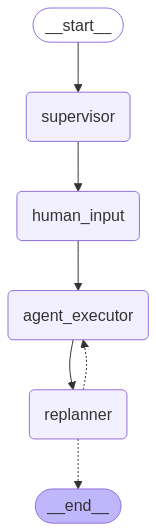

In [19]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Testing

In [20]:
initial_input = { "messages": [HumanMessage(content="I like coldplay")] }
thread = {"configurable": {"thread_id": "5", "user_id": "50"}}

# Run the graph until the first interruption
result = graph.invoke(initial_input, config = thread) 
print("Would you like to make any revisions to the plan?")


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================
System Message: Based on the plan, there is no need to route to sub-agents.

==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
Would you like to make any revisions to the plan?


In [21]:
# Resume interruption 
interrupt_info = ""
result = graph.invoke(Command(resume=interrupt_info), config = thread)


==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
System Message: No updates from user input. Will proceed with the original plan.

==================================================🤖 AGENT EXECUTOR FUNCTION CALLED==================================================
System Message: No agent executed based on current plan. Proceeding to replanner step.

==================================================🔄 REPLANNER FUNCTION CALLED==================================================
System Message: Thank you for letting us know that you're a Coldplay fan! We're glad to hear it. If you're interested, we can help you explore their latest albums, find similar artist recommendations, or even check out exclusive offers related to Coldplay. Just let us know how you'd like to enjoy more of their music or if there's anything else we can do to enhance your music experience. We're here to help!

===========================

Let's take a look at the memory!

In [22]:
user_id = "50"
namespace = ("memory_profile", user_id)
memory = in_memory_store.get(namespace, "user_memory").value

saved_music_preferences = memory.get("memory").music_preferences

print(saved_music_preferences)

['Coldplay']


Let's try it out with a different message!

In [23]:
initial_input = { "messages": [HumanMessage(content="My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?")] }
thread = {"configurable": {"thread_id": "103", "user_id": "50"}}

# Run the graph until the first interruption
result = graph.invoke(initial_input, config = thread) 
print("Would you like to make any revisions to the plan?")


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================
System Message: # ACTION PLAN: 

## Action 1

### Agent
invoice_information_subagent

### Task
Using the provided customer details (name: Aaron Mitchell and phone: +1 (204) 452-6452), query the invoice_information_subagent to retrieve the invoice number for the customer's most recent song purchase.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
Would you like to make any revisions to the plan?


In [24]:
# Resume interruption 
interrupt_info = ""
result = graph.invoke(Command(resume=interrupt_info), config = thread)


==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
System Message: No updates from user input. Will proceed with the original plan.

==================================================🤖 AGENT EXECUTOR FUNCTION CALLED==================================================
System Message: Executed invoice_information_subagent:
The invoice number for Aaron Mitchell's most recent song purchase is 342.

==================================================🔄 REPLANNER FUNCTION CALLED==================================================
System Message: Dear Aaron Mitchell,

Thank you for reaching out! I have located the invoice number for your most recent song purchase. The invoice number is 342.

Please let me know if you need any further assistance or additional information regarding your account or purchases.

Best regards,
Customer Support Team

==================================================🎬 SHOULD_END FUNCTION CALLE

## Part 2. Evaluating the agent


**Evaluations** are a quantitative way to measure performance of agents, which is important beacause LLMs don't always behave precitably — small changes in prompts, models, or inputs can significantly impact results. Evaluations provide a structured way to identify failures, compare changes across different versions of your applicaiton, and build more reliable AI applications.

Evaluations are made up of three components:

1. A **dataset test** inputs and expected outputs.
2. An **application or target function** that defines what you are evaluating, taking in inputs and returning the application output
3. **Evaluators** that score your target function's outputs.

![Evaluation](images/evals-conceptual.png) 

There are many ways you can evaluate an agent. Today, we will cover the three common types of agent evaluations:

1. **Final Response**: Evaluate the agent's final response.
2. **Single step**: Evaluate any agent step in isolation (e.g., whether it selects the appropriate tool).
3. **Trajectory**: Evaluate whether the agent took the expected path (e.g., of tool calls) to arrive at the final answer.

### 1. Evaluating the final response 
One way to evaluate an agent is to assess its overall performance on a task. This basically involves treating the agent as a black box and simply evaluating whether or not it gets the job done.
- Input: User input 
- Output: The agent's final response.
![final-response](images/final-response.png) 

#### Step 1. Create dataset 

In [17]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "response": "The Invoice ID of your most recent purchase was 342.",
    },
    {
        "question": "I'd like a refund.",
        "response": "I need additional information to help you with the refund. Could you please provide your customer identifier so that we can fetch your purchase history?",
    },
    {
        "question": "Hi I'm Luis. My phone number associated with my account is +55 (12) 3923-5555. I forgot my customer ID. Could you provide me with the information?",
        "response": 'Hi Luis! Your customer ID is 1.',
    },
    {
        "question": "Who recorded Wish You Were Here again?",
        "response": "Wish You Were Here is an album by Pink Floyd",
    },
    { 
        "question": "What albums do you have by Coldplay?",
        "response": "There are no Coldplay albums available in our catalog at the moment.",
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Final Response"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"response": ex["response"]} for ex in examples],
        dataset_id=dataset.id
    )

#### Step 2. Define application logic to be evaluated 

In [27]:
import uuid

async def run_graph(inputs: dict):
    """Run graph and track the final response."""
    # Creating configuration 
    thread_id = uuid.uuid4()
    configuration = {"thread_id": thread_id, "user_id" : "10"}

    # Invoke graph until interrupt 
    result = await graph.ainvoke({"messages": [
        { "role": "user", "content": inputs['question']}]}, config = configuration)
    # Proceed from human-in-the-loop 
    result = await graph.ainvoke(Command(resume=""), config={"thread_id": thread_id, "user_id" : "10"})
    
    return {"response": result['response']}

#### Step 3. Define evaluator 

In [19]:
pip install -q openevals

Note: you may need to restart the kernel to use updated packages.


In [20]:
from openevals.llm import create_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

# Using Open Eval pre-built 

correctness_evaluator = create_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=model,
)

print(CORRECTNESS_PROMPT)

You are an expert data labeler evaluating model outputs for correctness. Your task is to assign a score based on the following rubric:

<Rubric>
  A correct answer:
  - Provides accurate and complete information
  - Contains no factual errors
  - Addresses all parts of the question
  - Is logically consistent
  - Uses precise and accurate terminology

  When scoring, you should penalize:
  - Factual errors or inaccuracies
  - Incomplete or partial answers
  - Misleading or ambiguous statements
  - Incorrect terminology
  - Logical inconsistencies
  - Missing key information
</Rubric>

<Instructions>
  - Carefully read the input and output
  - Check for factual accuracy and completeness
  - Focus on correctness of information rather than style or verbosity
</Instructions>

<Reminder>
  The goal is to evaluate factual correctness and completeness of the response.
</Reminder>

<input>
{inputs}
</input>

<output>
{outputs}
</output>

Use the reference outputs below to help you evaluate the

In [22]:
# Custom definition of LLM-as-judge instructions
grader_instructions = """You are a teacher grading a quiz.

You will be given a QUESTION, the GROUND TRUTH (correct) RESPONSE, and the STUDENT RESPONSE.

Here is the grade criteria to follow:
(1) Grade the student responses based ONLY on their factual accuracy relative to the ground truth answer.
(2) Ensure that the student response does not contain any conflicting statements.
(3) It is OK if the student response contains more information than the ground truth response, as long as it is factually accurate relative to the  ground truth response.

Correctness:
True means that the student's response meets all of the criteria.
False means that the student's response does not meet all of the criteria.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# LLM-as-judge output schema
class Grade(TypedDict):
    """Compare the expected and actual answers and grade the actual answer."""
    reasoning: Annotated[str, ..., "Explain your reasoning for whether the actual response is correct or not."]
    is_correct: Annotated[bool, ..., "True if the student response is mostly or exactly correct, otherwise False."]

# Judge LLM
grader_llm = model.with_structured_output(Grade, method="json_schema", strict=True)

# Evaluator function
async def final_answer_correct(inputs: dict, outputs: dict, reference_outputs: dict) -> bool:
    """Evaluate if the final response is equivalent to reference response."""
    # Note that we assume the outputs has a 'response' dictionary. We'll need to make sure
    # that the target function we define includes this key.
    user = f"""QUESTION: {inputs['question']}
    GROUND TRUTH RESPONSE: {reference_outputs['response']}
    STUDENT RESPONSE: {outputs['response']}"""

    grade = await grader_llm.ainvoke([{"role": "system", "content": grader_instructions}, {"role": "user", "content": user}])
    return grade["is_correct"]

#### Step 4. Run evaluation 

In [28]:
from langsmith import Client

client = Client()

# Evaluation job and results
experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[final_answer_correct, correctness_evaluator],
    experiment_prefix="agent-o3mini-e2e-0",
    num_repetitions=1,
    max_concurrency=5,
)

View the evaluation results for experiment: 'agent-o3mini-e2e-0-bc9fa48c' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/19f4b8fe-f5a3-49a7-be94-af0f07c53fdb/compare?selectedSessions=277d727c-233f-4889-a9e4-8c80da7fa95b




0it [00:00, ?it/s]


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================
System Message: # ACTION PLAN: 

## Action 1

### Agent
customer_information_subagent

### Task
Verify the customer's account details by matching the provided name (Aaron Mitchell) and phone number (+1 (204) 452-6452) using the customer information subagent.

---

## Action 2

### Agent
invoice_information_subagent

### Task
Retrieve the invoice de

5it [00:49,  9.92s/it]


In [26]:
experiment_results.to_pandas()

,inputs.question,outputs.response,error,reference.response,feedback.final_answer_correct,feedback.correctness,execution_time,example_id,id
0,What albums do you have by Coldplay?,Our catalog currently does not list any albums...,None,There are no Coldplay albums available in our ...,True,True,19.061275,79951388-7675-45fb-8b7a-38965a325a88,d3d88241-6d0f-42d9-b83f-f75570af23af
1,Who recorded Wish You Were Here again?,"The album ""Wish You Were Here"" was recorded by...",None,Wish You Were Here is an album by Pink Floyd,True,True,19.995126,ba179a4b-3b96-48e2-a5b8-24a9785ddf68,0bdcebf8-81ac-48d6-8c6e-705900574493
2,My name is Aaron Mitchell. My number associate...,"Hello Aaron Mitchell, based on your account de...",None,The Invoice ID of your most recent purchase wa...,True,True,28.808338,68b8f87e-ea83-4804-a5fb-9cb3a7ecae2b,54e70c15-ede4-40c1-833a-a20714c7d979
3,Hi I'm Luis. My phone number associated with m...,"Hello Luis, based on our records, your custome...",None,Hi Luis! Your customer ID is 1.,True,True,22.690706,44e52532-b68c-46cb-a38f-17d642bd8955,9737d9ee-6ed3-4803-9635-c64f3fb61842
4,I'd like a refund.,Could you please provide your order or invoice...,None,I need additional information to help you with...,True,True,64.791966,bc0a06c0-68c1-4ea2-822b-17c08af7f61a,107c9c1b-fb80-459f-9722-26f97639ece7


### 2. Evaluating a single step of agent
Agents generally perform multiple actions. While it is useful to evaluate them end-to-end, it can also be useful to evaluate these individual actions, similar to the concept of unit testing in software development. This generally involves evaluating a single step of the agent - the LLM call where it decides what to do.

- Input: Input to a single step 
- Output: Output of that step, which is usually the LLM response
![single-step](images/single-step.png) 

#### Step 1. Create dataset 

In [76]:
examples = [
    {
        "messages": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?", 
        "route": ["invoice_information_subagent","music_catalog_information_subagent"]
    },
    {
        "messages": "What songs do you have by U2?", 
        "route": ["music_catalog_information_subagent"]
    },
    {
        "messages": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?", 
        "route": ["invoice_information_subagent"]
    },
    {
        "messages": "Hi I'm Luis. My phone number associated with my account is +55 (12) 3923-5555. I forgot my customer ID. Could you provide me with the information?", 
        "route": ["customer_information_subagent"]
    },
    {
        "messages": "Who recorded Wish You Were Here again? What other albums by them do you have?", 
        "route": ["music_catalog_information_subagent"]}
]


dataset_name = "LangGraph 101 Multi-Agent: Single Step"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs = [{"messages": ex["messages"]} for ex in examples],
        outputs = [{"route": ex["route"]} for ex in examples],
        dataset_id=dataset.id
    )

#### Step 2. Define application logic to be evaluated 

In [56]:
builder1 = StateGraph(State)
builder1.add_node("supervisor", supervisor)
builder1.add_edge(START, "supervisor")
builder1.add_edge("supervisor", END)

memory_saver1 = MemorySaver()
single_graph = builder.compile(checkpointer=memory_saver1, store=in_memory_store)

In [81]:
# Target function for running the relevant step
async def run_supervisor(inputs: dict):
    thread_id = uuid.uuid4()
    configuration = {"thread_id": thread_id, "user_id" : "10"}
    # in_memory_store
    result = await single_graph.ainvoke({"messages": [{ "role": "user", "content": inputs['messages']},]}, configuration)
    plan = result["action_plan"]
    subagent_route = [p.subagent for p in plan]
    return {"route": subagent_route}

In [59]:
# Target function for running the relevant step

# I RUN INTO ERRORS WITH THIS - NOT HAVING MEMORY STORE? but how would i pass it on? (can't pass it in invoke)


# async def run_supervisor(inputs: dict):
#     thread_id = uuid.uuid4()
#     configuration = {"thread_id": thread_id, "user_id" : "10"}
#     # in_memory_store
#     result = await graph.nodes['supervisor'].ainvoke(inputs, configuration)
#     return {"route": result.action_plan}

#### Step 3. Define evaluator 

In [79]:
def correct(outputs: dict, reference_outputs: dict) -> bool:
    """Check if the agent chose the correct route."""
    return outputs["route"] == reference_outputs["route"]

#### Step 4. Run evaluation 

In [82]:
experiment_results = await client.aevaluate(
    run_supervisor,
    data=dataset_name,
    evaluators=[correct],
    experiment_prefix="agent-o3mini-single",
    max_concurrency=5,
)

View the evaluation results for experiment: 'agent-o3mini-single-f7d14aed' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/89eb06ef-a841-458d-8ba4-6401be226a18/compare?selectedSessions=50edec76-19f2-468f-945e-1173895160d1




0it [00:00, ?it/s]


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================


1it [00:02,  2.75s/it]

System Message: # ACTION PLAN: 

## Action 1

### Agent
music_catalog_information_subagent

### Task
Query the music catalog information subagent to retrieve all songs by the artist 'U2' from the digital music store's catalog.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
System Message: # ACTION PLAN: 

## Action 1

### Agent
invoice_information_subagent

### Task
Query the invoice system to retrieve the most recent purchase for customer ID 1.

---

## Action 2

### Agent
music_catalog_information_subagent

### Task
Search the music catalog for albums by U2.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================


2it [00:05,  2.59s/it]

System Message: # ACTION PLAN: 

## Action 1

### Agent
customer_information_subagent

### Task
Use the customer's provided information (name: Luis and phone number: +55 (12) 3923-5555) to retrieve his account details from the database and extract the associated customer ID.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================


3it [00:07,  2.36s/it]

System Message: # ACTION PLAN: 

## Action 1

### Agent
invoice_information_subagent

### Task
Use the invoice_information_subagent to retrieve the most recent invoice for a song purchase associated with the account identified by the phone number +1 (204) 452-6452 and name Aaron Mitchell.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================


4it [00:14,  4.45s/it]

System Message: # ACTION PLAN: 

## Action 1

### Agent
music_catalog_information_subagent

### Task
Use the music_catalog_information_subagent to retrieve the album 'Wish You Were Here' from the music catalog, extract the recording artist from its details, and then retrieve a list of other albums by that artist available in the store (excluding 'Wish You Were Here' if necessary).



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================


5it [00:15,  3.04s/it]


In [83]:
experiment_results.to_pandas()

,inputs.messages,outputs.route,error,reference.route,feedback.correct,execution_time,example_id,id
0,What songs do you have by U2?,[music_catalog_information_subagent],None,[music_catalog_information_subagent],True,2.731097,8a3c116e-9fbd-4e3d-952d-fd7d7ba4369e,c197bff0-cd2a-4fb2-9144-fa84a9432c98
1,My customer ID is 1. What's my most recent pur...,"[invoice_information_subagent, music_catalog_i...",None,"[invoice_information_subagent, music_catalog_i...",True,3.467404,a0070b30-1ae0-4e4f-929a-a61de35fb86d,e4de39d4-0059-4554-9871-25e606c974e4
2,Hi I'm Luis. My phone number associated with m...,[customer_information_subagent],None,[customer_information_subagent],True,5.210685,72762c53-d233-42a1-b20e-3d79a01a92a8,0fbacaa2-c69b-4e5b-8a4b-df907741ee67
3,My name is Aaron Mitchell. My number associate...,[invoice_information_subagent],None,[invoice_information_subagent],True,7.317326,5deefe65-a5a9-4719-83df-c4394f9dbca6,364a8fb4-c2b6-4c31-be64-8d894ce9fbff
4,Who recorded Wish You Were Here again? What ot...,[music_catalog_information_subagent],None,[music_catalog_information_subagent],True,14.970225,69ec4392-c580-4d0b-8012-9616ccc0669c,4ae06727-8c08-46e6-b5af-c82dc1619e45


### 3. Evaluating an agent's trajectory 
Evaluating an agent's trajectory involves evaluating all the steps an agent took. The evaluator here is some function over the steps taken. Examples of evaluators include an exact match for each tool name in the sequence or the number of "incorrect" steps taken.

- Input: User input to the overall agent 
- Output: A list of steps taken.
![trajectory](images/trajectory.png) 

#### Step 1. Create dataset 

In [52]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    {
        "question": "My customer ID is 1. What's my most recent purchase? and What albums does the catalog have by U2?",
        "trajectory": ["supervisor", "human_input", "human_input", "agent_executor", "replanner", "agent_executor", "replanner"],
    },
    {
        "question": "What songs do you have by U2?",
        "trajectory": ["supervisor", "human_input", "human_input", "agent_executor", "replanner"],
    },
    {
        "question": "My name is Aaron Mitchell. My number associated with my account is +1 (204) 452-6452. I am trying to find the invoice number for my most recent song purchase. Could you help me with it?",
        "trajectory": ["supervisor", "human_input", "human_input", "agent_executor", "replanner"],
    },
    {
        "question": "Hi I'm Luis. My phone number associated with my account is +55 (12) 3923-5555. I forgot my customer ID. Could you provide me with the information? ",
        "trajectory": ["supervisor", "human_input", "human_input", "agent_executor", "replanner"],
    },
    {
        "question": "Who recorded Wish You Were Here again? What other albums by them do you have?",
        "trajectory": ["supervisor", "human_input", "human_input", "agent_executor", "replanner"],
    },
]

dataset_name = "LangGraph 101 Multi-Agent: Trajectory"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"question": ex["question"]} for ex in examples],
        outputs=[{"trajectory": ex["trajectory"]} for ex in examples],
        dataset_id=dataset.id
    )

#### Step 2. Define application logic to be evaluated 

In [51]:
async def run_graph(inputs: dict) -> dict:
    """Run graph and track the trajectory it takes along with the final response."""
    trajectory = []
    thread_id = uuid.uuid4()
    configuration = {"thread_id": thread_id, "user_id" : "10"}
    # Set stream_mode="debug" to stream all possible events: https://langchain-ai.github.io/langgraph/concepts/streaming

    # Run until interrupt 
    async for chunk in graph.astream({"messages": [
            {
                "role": "user",
                "content": inputs['question'],
            }
        ]}, config = configuration, stream_mode="debug"):
        # Event type for entering a node
        if chunk['type'] == 'task':
            # Record the node name
            trajectory.append(chunk['payload']['name'])

    # Resume from interrupt
    async for chunk in graph.astream(Command(resume=""), config = configuration, stream_mode="debug"):
        # Event type for entering a node
        if chunk['type'] == 'task':
            # Record the node name
            trajectory.append(chunk['payload']['name'])
    return {"trajectory": trajectory}

#### Step 3. Define evaluator 

In [54]:
def evaluate_exact_match(outputs: dict, reference_outputs: dict):
    """Evaluate whether the trajectory exactly matches the expected output"""
    return {
        "key": "exact_match", 
        "score": outputs["trajectory"] == reference_outputs["trajectory"]
    }

def evaluate_extra_steps(outputs: dict, reference_outputs: dict) -> dict:
    # ["step1", "step2", "step3"]
    # ["step3", "step2", "step1"]
    """Evaluate the number of unmatched steps in the agent's output."""
    i = j = 0
    unmatched_steps = 0

    while i < len(reference_outputs['trajectory']) and j < len(outputs['trajectory']):
        if reference_outputs['trajectory'][i] == outputs['trajectory'][j]:
            i += 1  # Match found, move to the next step in reference trajectory
        else:
            unmatched_steps += 1  # Step is not part of the reference trajectory
        j += 1  # Always move to the next step in outputs trajectory

    # Count remaining unmatched steps in outputs beyond the comparison loop
    unmatched_steps += len(outputs['trajectory']) - j

    return {
        "key": "unmatched_steps",
        "score": unmatched_steps,
    }

#### Step 4. Run evaluation 

In [55]:
experiment_results = await client.aevaluate(
    run_graph,
    data=dataset_name,
    evaluators=[evaluate_extra_steps, evaluate_exact_match],
    experiment_prefix="agent-o3mini-trajectory",
    num_repetitions=1,
    max_concurrency=4,
)
experiment_results.to_pandas()

View the evaluation results for experiment: 'agent-o3mini-trajectory-22e96374' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/77697358-8cdf-4f96-b3a4-f94f7134fa7d/compare?selectedSessions=7d409b9c-1851-4654-9ba4-d21c861cc54e




0it [00:00, ?it/s]


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================

==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================
System Message: # ACTION PLAN: 

## Action 1

### Agent
invoice_information_subagent

### Task
Retrieve the most recent purchase for customer ID 1 using the invoice system.

---

## Action 2

### Agent
music_catalog_information_subagent

### Task
Retrieve all albums from the music catalog that are by U2.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================

========================================

3it [00:26,  6.12s/it]

System Message: # ACTION PLAN: 

## Action 1

### Agent
customer_information_subagent

### Task
Use the customer_information_subagent to look up Luis's account details with the provided phone number (+55 (12) 3923-5555) and retrieve his customer ID.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================

==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
System Message: No updates from user input. Will proceed with the original plan.

==================================================🤖 AGENT EXECUTOR FUNCTION CALLED==================================================
System Message: Executed customer_information_subagent:
I have retrieved Luis's account details using the provided phone number. His customer ID is 1. If you need any further assistance, feel free to ask!

==================================================🔄 REPLANNER FUN

5it [00:38,  7.72s/it]


,inputs.question,outputs.trajectory,error,reference.trajectory,feedback.unmatched_steps,feedback.exact_match,execution_time,example_id,id
0,What songs do you have by U2?,"[supervisor, human_input, human_input, agent_e...",None,"[supervisor, human_input, human_input, agent_e...",0,True,19.247168,b54ea61e-175c-45bb-990c-202fdc6f6c60,46754116-506e-43d1-9e79-5bf3b97c9a0b
1,My customer ID is 1. What's my most recent pur...,"[supervisor, human_input, human_input, agent_e...",None,"[supervisor, human_input, human_input, agent_e...",0,True,24.949736,770e4240-3fe4-469d-a759-4c3290df4fa2,d3159399-caa0-4711-90f8-463c54c0f8a1
2,My name is Aaron Mitchell. My number associate...,"[supervisor, human_input, human_input, agent_e...",None,"[supervisor, human_input, human_input, agent_e...",0,True,25.177493,47fd9666-4c44-4e8f-977d-ce33531a691e,63967e33-45a0-48fa-90e9-541e814b8758
3,Who recorded Wish You Were Here again? What ot...,"[supervisor, human_input, human_input, agent_e...",None,"[supervisor, human_input, human_input, agent_e...",0,True,26.202243,69e0bc26-5053-41ba-9cab-8a01d7b49ca5,ea286117-0037-40ac-bcca-51a24d0ebc78
4,Hi I'm Luis. My phone number associated with m...,"[supervisor, human_input, human_input, agent_e...",None,"[supervisor, human_input, human_input, agent_e...",0,True,19.060274,e77899df-8f21-4ef0-b492-1476ebeb4390,b9cc6940-7d63-499b-b6cc-aabb0b66cd15
